In [1]:
import pandas as pd
import geopandas as gpd
import osmnx as osm
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from pyproj import Transformer
from shapely.geometry import *
import networkx as nx
import folium
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from cdlib import algorithms, viz, evaluation
import numpy as np

Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'infomap', 'bayanpy', 'graph_tool'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'pyclustering', 'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'infomap'}


In [285]:
# import all the data
trip_data = pd.read_csv('../Data/02_Processed_Data/cleaned_trip_data.csv')
trip_data['Start date'] = pd.to_datetime(trip_data['Start date'])
trip_data['End date'] = pd.to_datetime(trip_data['End date'])
station_data = pd.read_csv('../Data/02_Processed_Data/cleaned_station_data.csv')
station_data = gpd.GeoDataFrame(station_data, geometry=gpd.points_from_xy(station_data['lon'], station_data['lat'], crs='epsg:4326'))
station_data = osm.project_gdf(station_data)
central_london = osm.io.load_graphml('../Data/02_Processed_Data/Central_london.osm')

In [286]:
# add the longitude and latitude of the start and end stations
trip_data = trip_data.merge(station_data[['commonName', 'lat', 'lon']], left_on='Start station', right_on='commonName', suffixes=('', '_start'))
trip_data = trip_data.merge(station_data[['commonName', 'lat', 'lon']], left_on='End station', right_on='commonName', suffixes=('', '_end'))
# drop the commonName columns
trip_data.drop(columns=['commonName', 'commonName_end'], inplace=True)
# rename the lat and lon column to lat_start, lon_start
trip_data.rename(columns={'lat': 'lat_start', 'lon': 'lon_start'}, inplace=True)

In [287]:
# Get the CRS of the projected graph
crs_proj = central_london.graph['crs']

# Create a transformer to convert lat/lon to the projected CRS
transformer = Transformer.from_crs("epsg:4326", crs_proj, always_xy=True)

# Methodology

In this section we will show the methodology used to solve the problem. The methodology is divided into the following steps:

1. Clustering
2. Community Detection Algotithm


## (01) Clustering

### Clustering based on the location of the stations

In [220]:
coords = station_data[['lat', 'lon']].to_numpy()

#Determine the number of clusters (k)
num_clusters = 5  # Adjust this value based on your dataset and requirements

# Apply K-Means
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(coords)
labels = kmeans.labels_

# Add the cluster labels to the original dataframe
station_data['Cluster'] = labels

# # Plot the clusters
# plt.figure(figsize=(10, 8))
# plt.scatter(station_data['lon'], station_data['lat'], c=station_data['cluster'], cmap='viridis', marker='o')
# plt.title(f'K-Means Clustering of Bike Stations (k={num_clusters})')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.colorbar(label='Cluster Label')
# plt.show()

# Create a folium map
# Plot the stations on a map with folium
map_center = [51.509865, -0.118092]  # Center the map around central London
bike_map = folium.Map(location=map_center, zoom_start=12)

# Define a color palette for the clusters
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen']

for i, row in station_data.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=5,
        color=colors[row['Cluster'] % len(colors)],
        fill=True,
        fill_color=colors[row['Cluster'] % len(colors)],
        fill_opacity=0.7,
        popup=f"Station: {row['commonName']}<br>Cluster: {row['Cluster']}"
    ).add_to(bike_map)

# Save the map to an HTML file
bike_map.save('../Data/03_Results/Clustering_Map_Location.html')

# Save the clustered station data
station_data.to_csv('../Data/03_Results/Clustered_Stations_Location.csv', index=False)
station_data.drop(columns='Cluster', inplace=True)

### Clustering based on the demand pattern

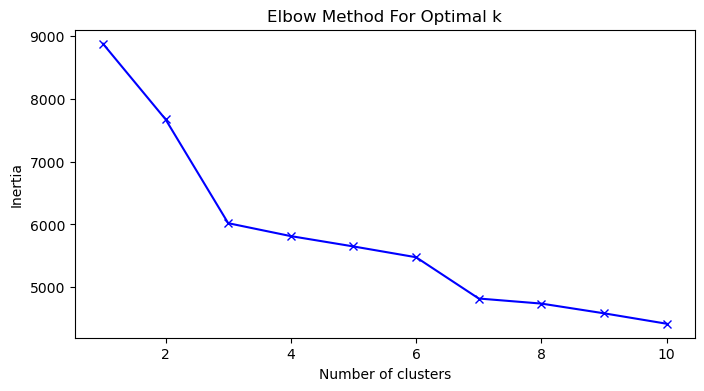

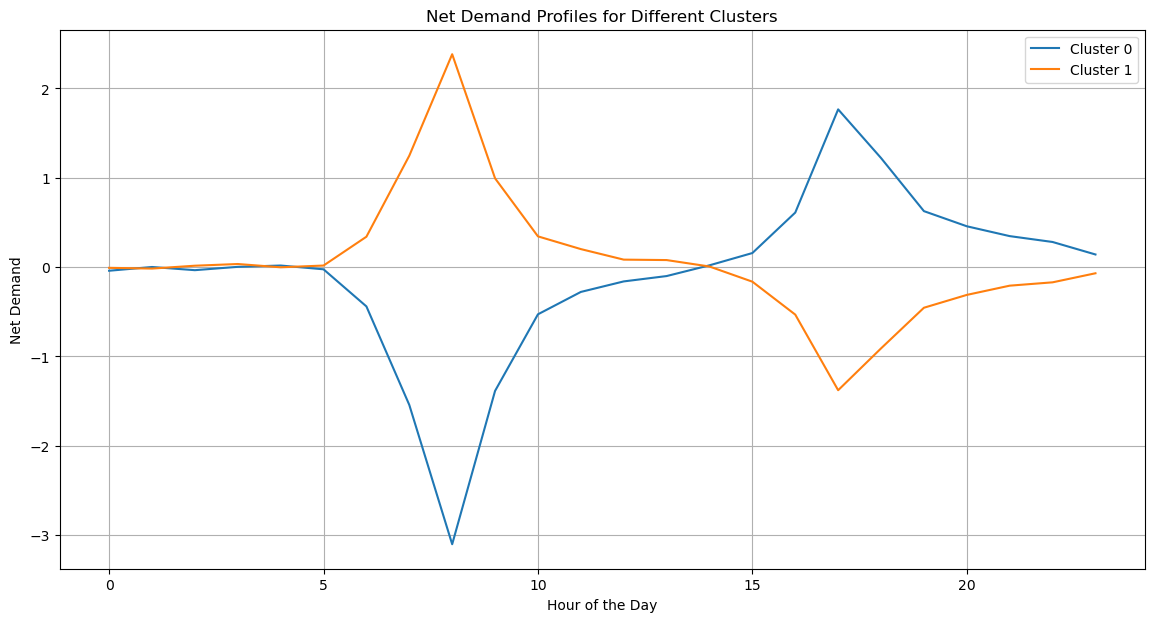

In [277]:
# Extract date and hour from the start date
trip_data['Date'] = pd.to_datetime(trip_data['Start date']).dt.date
trip_data['hour_of_the_day'] = pd.to_datetime(trip_data['Start date']).dt.hour

# Group by start station, hour, and date, then count start trips
df_start_grouped = trip_data.groupby(['Start station', 'hour_of_the_day', 'Date']).size().reset_index(name='num_start_trips')

# Calculate the average number of start trips per hour for each station
df_start_average = df_start_grouped.groupby(['Start station', 'hour_of_the_day'])['num_start_trips'].mean().reset_index(name='average_number_of_start_trips')

# Group by end station, hour, and date, then count end trips
df_end_grouped = trip_data.groupby(['End station', 'hour_of_the_day', 'Date']).size().reset_index(name='num_end_trips')

# Calculate the average number of end trips per hour for each station
df_end_average = df_end_grouped.groupby(['End station', 'hour_of_the_day'])['num_end_trips'].mean().reset_index(name='average_number_of_end_trips')

# Merge the start and end average data on station and hour
df_merged = pd.merge(df_start_average, df_end_average, left_on=['Start station', 'hour_of_the_day'], right_on=['End station', 'hour_of_the_day'], suffixes=('_start', '_end')).fillna(0)

# Calculate the net demand (start - end)
df_merged['net_demand'] = df_merged['average_number_of_start_trips'] - df_merged['average_number_of_end_trips']

# Pivot the data to have one row per station and 24 columns for each hour of the day
pivoted_data = df_merged.pivot(index='Start station', columns='hour_of_the_day', values='net_demand').fillna(0)

# Normalize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(pivoted_data)

# Elbow Method to find the optimal number of clusters
inertia = []
K = range(1, 11)  # Try 1 to 10 clusters
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(8, 4))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

# Based on the plot, choose the optimal number of clusters
#optimal_k = int(input("Enter the optimal number of clusters based on the Elbow Method plot: "))
optimal_k = 2

# Apply K-Means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
pivoted_data['Cluster'] = kmeans.fit_predict(data_scaled)

# Reset the index to save the data properly
clustered_data = pivoted_data.reset_index()

# Save the clustered data to a new CSV file
clustered_data.to_csv('clustered_net_demand_data.csv', index=False)

# Merge the cluster data with station location data
clustered_stations = pd.merge(clustered_data, station_data, left_on='Start station', right_on='commonName')

# Plot the stations on a map with folium
map_center = [51.509865, -0.118092]  # Center the map around central London
bike_map = folium.Map(location=map_center, zoom_start=12)

# Define a color palette for the clusters
colors = ['red', 'blue', 'green', 'purple']

for i, row in clustered_stations.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=5,
        color=colors[row['Cluster'] % len(colors)],
        fill=True,
        fill_color=colors[row['Cluster'] % len(colors)],
        fill_opacity=0.7,
        popup=f"Station: {row['commonName']}<br>Cluster: {row['Cluster']}"
    ).add_to(bike_map)

# Plotting the clusters
plt.figure(figsize=(14, 7))
for cluster in range(optimal_k):
    cluster_data = pivoted_data[pivoted_data['Cluster'] == cluster].drop('Cluster', axis=1)
    cluster_mean = cluster_data.mean(axis=0)
    plt.plot(cluster_mean.index, cluster_mean.values, label=f'Cluster {cluster}')

plt.xlabel('Hour of the Day')
plt.ylabel('Net Demand')
plt.title('Net Demand Profiles for Different Clusters')
plt.legend()
plt.grid(True)
plt.show()

# Save the map to an HTML file
bike_map.save('../Data/03_Results/Clustering_Map_Demand_Pattern.html')

# Save the clusters as an csv file
pivoted_data.to_csv('../Data/03_Results/Clustered_Stations_Demand_Pattern.csv')

## (02) Community Detection Algortihm

In [222]:
# Create the graph
G = nx.Graph()

# Add edges between stations with weights as the number of trips
for _, row in trip_data.iterrows():
    start_station = row['Start station']
    end_station = row['End station']
    if G.has_edge(start_station, end_station):
        G[start_station][end_station]['weight'] += 1
    else:
        G.add_edge(start_station, end_station, weight = 1)

In [223]:
# Function to visualize the graph on a html map
def visualize_and_safe_communities(G, coms, station_data, algorithm, package, parameters = None, map_center=[51.509865, -0.118092], zoom_start=12, save_path='../Data/03_Results/'):
    # Create a mapping of nodes to their communities
    node_community = {}
    for community_id, nodes in enumerate(coms.communities):
        for node in nodes:
            node_community[node] = community_id

    # Create a DataFrame with stations and their communities
    stations = list(G.nodes())
    communities = [node_community[station] for station in stations]
    community_df = pd.DataFrame({'Station': stations, 'Community': communities})

    # Merge the cluster data with station location data
    clustered_stations = pd.merge(community_df, station_data, left_on='Station', right_on='commonName')

    # Plot the stations on a map with folium
    bike_map = folium.Map(location=map_center, zoom_start=zoom_start)

    # Define a color palette for the clusters
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen']

    for i, row in clustered_stations.iterrows():
        folium.CircleMarker(
            location=[row['lat'], row['lon']],
            radius=5,
            color=colors[row['Community'] % len(colors)],
            fill=True,
            fill_color=colors[row['Community'] % len(colors)],
            fill_opacity=0.7,
            popup=f"Station: {row['commonName']}<br>Community: {row['Community']}"
        ).add_to(bike_map)

    # Save the map to an HTML file
    map_file_path = f"{save_path}Community_Detection_Alg_{algorithm}_with_{package}_using{parameters}_map.html"
    bike_map.save(map_file_path)

    # Save the DataFrame to a CSV file
    csv_file_path = f"{save_path}Community_Detection_Alg_{algorithm}_with_{package}_using{parameters}_result.csv"
    community_df.to_csv(csv_file_path, index=False)

    print(f"Map saved to {map_file_path}")
    print(f"Community data saved to {csv_file_path}")

### Leiden: cdlib package

In [224]:
coms_leiden_cdlib_no_parameters = algorithms.leiden(G)
visualize_and_safe_communities(G, coms_leiden_cdlib_no_parameters, station_data, 'Leiden', 'CDLib')
print('Modularity_score:', evaluation.newman_girvan_modularity(G, coms_leiden_cdlib_no_parameters).score)

Map saved to ../Data/03_Results/Community_Detection_Alg_Leiden_with_CDLib_usingNone_map.html
Community data saved to ../Data/03_Results/Community_Detection_Alg_Leiden_with_CDLib_usingNone_result.csv
Modularity_score: 0.23316494269389182


### Louvain: cdlib package

In [225]:
coms_louvain_cdlib_no_parameters = algorithms.louvain(G)
visualize_and_safe_communities(G, coms_louvain_cdlib_no_parameters, station_data, 'Louvain', 'CDLib')
print('Modularity_score:', evaluation.newman_girvan_modularity(G, coms_louvain_cdlib_no_parameters).score)

Map saved to ../Data/03_Results/Community_Detection_Alg_Louvain_with_CDLib_usingNone_map.html
Community data saved to ../Data/03_Results/Community_Detection_Alg_Louvain_with_CDLib_usingNone_result.csv
Modularity_score: 0.28219911161087596


In [246]:
coms_louvain_cdlib_random_True = algorithms.louvain(G, randomize=True)
visualize_and_safe_communities(G, coms_louvain_cdlib_random_True, station_data, 'Louvain', 'CDLib', 'random=True')
print('Modularity_score:', evaluation.newman_girvan_modularity(G, coms_louvain_cdlib_random_True).score)


Map saved to ../Data/03_Results/Community_Detection_Alg_Louvain_with_CDLib_usingrandom=True_map.html
Community data saved to ../Data/03_Results/Community_Detection_Alg_Louvain_with_CDLib_usingrandom=True_result.csv
Modularity_score: 0.2767212598594444


In [276]:
resolution = 1.02
coms_louvain_cdlib_size_smaller = algorithms.louvain(G, weight='weight', resolution=resolution, randomize=False)
visualize_and_safe_communities(G, coms_louvain_cdlib_random_True, station_data, 'Louvain', 'CDLib', f'resolution_{resolution}')
print('Modularity_score:', evaluation.newman_girvan_modularity(G, coms_louvain_cdlib_size_smaller).score)


Map saved to ../Data/03_Results/Community_Detection_Alg_Louvain_with_CDLib_usingresolution_1.02_map.html
Community data saved to ../Data/03_Results/Community_Detection_Alg_Louvain_with_CDLib_usingresolution_1.02_result.csv
Modularity_score: 0.2813953301874957


In [270]:
modularities = []
for i in range(100):
    coms_louvain_cdlib_size_smaller = algorithms.louvain(G, weight='weight', resolution=resolution, randomize=True)
    modularity = evaluation.newman_girvan_modularity(G, coms_louvain_cdlib_size_smaller).score
    modularities.append(modularity)


In [273]:
print(np.average(modularities))
print(np.median(modularities))
print(np.std(modularities))


0.2787100713673608
0.2799483473334618
0.002939378474393563


In [208]:
small_steps = [i/100 for i in range (0,100,5)]
medium_steps = [i for i in range(1, 25)]
large_steps = [i for i in range(25, 500, 25)]
very_large_steps = [i for i in range(500, 10000, 1000)]
steps = small_steps + medium_steps + large_steps + very_large_steps
len(steps)

73

In [209]:
# modularity_scores = {}
# for step in steps:
#     coms_louvain_cdlib_resolution = algorithms.louvain(G, weight='weight', resolution=step)
#     visualize_and_safe_communities(G, coms_louvain_cdlib_resolution, station_data, 'Louvain', 'CDLib', f'resolution_{step}')
#     print('Modularity_score:', evaluation.newman_girvan_modularity(G, coms_louvain_cdlib_resolution).score)
#     modularity_scores[step] = evaluation.newman_girvan_modularity(G, coms_louvain_cdlib_resolution).score

In [210]:
# modularity_scores_df = pd.DataFrame(modularity_scores.items(), columns=['Resolution', 'Modularity Score'])
# modularity_scores_df

In [211]:
# modularity_scores_with_averages = {}
# for step in steps:
#     modularities = []
#     for i in range(10):
#         coms_louvain_cdlib_resolution = algorithms.louvain(G, weight='weight', resolution=step)
#         visualize_and_safe_communities(G, coms_louvain_cdlib_resolution, station_data, 'Louvain', 'CDLib', f'resolution_{step}')
#         modularity = evaluation.newman_girvan_modularity(G, coms_louvain_cdlib_resolution).score
#         print('Modularity_score:', modularity)
#         modularities.append(modularity)
#     modularity_scores[step] = np.mean(modularities)

In [212]:
# moodularity_scores_averages_df = pd.DataFrame(modularity_scores.items(), columns=['Resolution', 'Modularity Score'])
# moodularity_scores_averages_df

### Markov Clustering: cdlib package

In [213]:
coms_markov_cdlib_no_parameters = algorithms.markov_clustering(G)
visualize_and_safe_communities(G, coms_markov_cdlib_no_parameters, station_data, 'Markov', 'CDLib')
print('Modularity_score:', evaluation.newman_girvan_modularity(G, coms_markov_cdlib_no_parameters).score)


Map saved to ../Data/03_Results/Community_Detection_Alg_Markov_with_CDLib_usingNone_map.html
Community data saved to ../Data/03_Results/Community_Detection_Alg_Markov_with_CDLib_usingNone_result.csv
Modularity_score: 0.014892372008928678


### Inside these communities we will use the clustering based on the demand pattern to create the final clusters

In [214]:
# Inside these communities we will use the clustering based on the demand pattern to create the final clusters
# Get the communities of the stations
community_results = pd.read_csv('../Data/03_Results/Community_Detection_Alg_Louvain_with_CDLib_usingNone_result.csv')
station_data['Community'] = community_results['Community']
data_frames = []

for community in station_data['Community'].unique():
    # Filter the stations in the community
    community_stations = station_data[station_data['Community'] == community]
    community_trip_data = trip_data[trip_data['Start station'].isin(community_stations['commonName'])]

    # Group by start station, hour, and date, then count start trips
    df_start_grouped = community_trip_data.groupby(['Start station', 'hour_of_the_day', 'Date']).size().reset_index(name='num_start_trips')

    # Calculate the average number of start trips per hour for each station
    df_start_average = df_start_grouped.groupby(['Start station', 'hour_of_the_day'])['num_start_trips'].mean().reset_index(name='average_number_of_start_trips')

    # Group by end station, hour, and date, then count end trips
    df_end_grouped = community_trip_data.groupby(['End station', 'hour_of_the_day', 'Date']).size().reset_index(name='num_end_trips')

    # Calculate the average number of end trips per hour for each station
    df_end_average = df_end_grouped.groupby(['End station', 'hour_of_the_day'])['num_end_trips'].mean().reset_index(name='average_number_of_end_trips')

    # Merge the start and end average data on station and hour
    df_merged = pd.merge(df_start_average, df_end_average, left_on=['Start station', 'hour_of_the_day'], right_on=['End station', 'hour_of_the_day'], suffixes=('_start', '_end')).fillna(0)

    # Calculate the net demand (start - end)
    df_merged['net_demand'] = df_merged['average_number_of_start_trips'] - df_merged['average_number_of_end_trips']

    # Pivot the data to have one row per station and 24 columns for each hour of the day
    pivoted_data = df_merged.pivot(index='Start station', columns='hour_of_the_day', values='net_demand').fillna(0)

    # Normalize the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(pivoted_data)

    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=2, random_state=42)
    pivoted_data['Cluster'] = kmeans.fit_predict(data_scaled)

    # Reset the index to save the data properly
    clustered_data = pivoted_data.reset_index()

    # Save the clustered data to a new CSV file
    #clustered_data.to_csv(f'../Data/03_Results/Clustered_Stations_Demand_Pattern_Community_{community}.csv', index=False)

    # Merge the cluster data with station location data
    data_frames.append(pd.merge(clustered_data, community_stations, left_on='Start station', right_on='commonName'))

# Concatenate all the data frames
final_clustered_stations = pd.concat(data_frames)

# Plot the stations on a map with folium
map_center = [51.509865, -0.118092]  # Center the map around central London
bike_map = folium.Map(location=map_center, zoom_start=12)
import matplotlib.colors as mcolors

# Define a color palette for the communities
community_colors = {
    0: 'red',
    1: 'blue',
    2: 'green',
    3: 'purple',
    4: 'orange',
    # Add more if needed for additional communities
}

# Function to determine the color based on community and cluster
def get_color(community, cluster):
    base_color = community_colors.get(community, 'gray')  # Default to gray if community not in predefined colors
    if cluster == 0:
        return mcolors.to_hex(mcolors.to_rgba(base_color, 0.3))  # Lighter color for cluster 0
    elif cluster == 1:
        return mcolors.to_hex(mcolors.to_rgba(base_color, 1.0))  # Darker color for cluster 1

# Iterate through the rows and add CircleMarker to the map
for i, row in final_clustered_stations.iterrows():
    color = get_color(row['Community'], row['Cluster'])  # Determine the color based on community and cluster
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"Station: {row['commonName']}<br>Community: {row['Community']}<br>Cluster: {row['Cluster']}"
    ).add_to(bike_map)

# Save the map to an HTML file
bike_map.save('../Data/03_Results/Community_Clustering_Map_Demand_Pattern_in_Communities.html')

# Save the clusters as a CSV file
final_clustered_stations.to_csv('../Data/03_Results/Community_Clustered_Stations_Demand_Pattern_in_Communities.csv', index=False)




In [215]:
clustered_stations

,Start station,0,1,2,3,4,5,6,7,8,...,20,21,22,23,Cluster,commonName,lat,lon,NbDocks,geometry
0,"Abbey Orchard Street, Westminster",0.250000,-0.333333,0.0,0.00,0.0,0.000000,-0.051948,-0.931250,-5.195455,...,0.166667,0.112500,-0.125000,0.375000,0,"Abbey Orchard Street, Westminster",51.498125,-0.132102,29,POINT (699058.184 5709120.832)
1,"Abingdon Green, Westminster",0.375000,0.000000,0.0,4.00,0.0,0.000000,-0.130435,-0.576087,-2.685868,...,0.003788,-0.333333,-0.035714,-0.071429,1,"Abingdon Green, Westminster",51.497640,-0.125972,20,POINT (699485.700 5709083.604)
2,"Albany Street, The Regent's Park",-0.200000,0.000000,0.0,0.00,0.0,0.000000,-0.350000,0.335556,2.763492,...,-0.548789,-0.416667,-0.228571,-0.055556,1,"Albany Street, The Regent's Park",51.528302,-0.144466,27,POINT (698069.173 5712442.421)
3,"Albert Embankment, Vauxhall",0.000000,0.000000,0.0,0.00,0.0,0.000000,-0.110294,0.292354,-0.196596,...,-0.428947,-0.062500,-0.025000,0.107143,1,"Albert Embankment, Vauxhall",51.490435,-0.122806,24,POINT (699736.916 5708291.177)
4,"Albert Gate, Hyde Park",-2.000000,0.000000,0.0,0.00,0.0,0.000000,0.111111,-0.917051,-0.107345,...,0.392857,-0.389610,0.395833,-0.075000,1,"Albert Gate, Hyde Park",51.502953,-0.158456,34,POINT (697208.464 5709586.252)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,"Wood Street, Guildhall",0.000000,0.000000,0.0,0.00,0.0,-0.076923,-0.980769,-5.344575,-3.612665,...,0.166008,0.363636,0.190476,0.000000,0,"Wood Street, Guildhall",51.517008,-0.093885,17,POINT (701626.866 5711324.937)
366,"Woodstock Street, Mayfair",0.500000,0.166667,0.0,0.00,0.0,0.000000,0.000000,0.000000,-0.914286,...,-0.032468,0.308081,0.437500,0.166667,0,"Woodstock Street, Mayfair",51.514105,-0.147301,21,POINT (697934.139 5710856.286)
367,"Wormwood Street, Liverpool Street",-0.144231,0.333333,0.0,-0.25,0.0,-0.170940,-0.540984,1.259345,2.946493,...,0.071429,-0.309441,-0.002217,0.448413,1,"Wormwood Street, Liverpool Street",51.516154,-0.082422,16,POINT (702425.805 5711261.649)
368,"Worship Street, Shoreditch",1.230769,0.000000,0.0,0.00,0.0,0.000000,-0.421053,-2.144460,-6.611205,...,0.456579,0.719697,0.141026,-2.322222,0,"Worship Street, Shoreditch",51.521668,-0.079608,51,POINT (702596.524 5711882.493)


In [292]:
community_data = pd.read_csv('../Data/03_Results/Community_Detection_Alg_Louvain_with_CDLib_usingresolution_0.2_result.csv')
community_data.rename(columns={'Station': 'commonName'}, inplace=True)
station_data = station_data.merge(community_data[['commonName', 'Community']], on='commonName')
station_data

,commonName,lat,lon,NbDocks,geometry,Station_number,Community
0,"River Street , Clerkenwell",51.529163,-0.109970,19,POINT (700457.690 5712632.137),1023,1
1,"Christopher Street, Liverpool Street",51.521283,-0.084605,32,POINT (702251.641 5711825.859),1012,1
2,"St. Chad's Street, King's Cross",51.530059,-0.120973,23,POINT (699690.724 5712701.655),1013,0
3,"Sedding Street, Sloane Square",51.493130,-0.156876,27,POINT (697360.546 5708498.365),3420,3
4,"Broadcasting House, Marylebone",51.518117,-0.144228,18,POINT (698129.901 5711310.670),3424,0
...,...,...,...,...,...,...,...
365,"Soho Square , Soho",51.515631,-0.132328,57,POINT (698966.191 5711066.572),1052,0
366,"Upper Grosvenor Street, Mayfair",51.510130,-0.155757,18,POINT (697364.716 5710391.488),10621,0
367,"Park Lane, Mayfair",51.505426,-0.150817,18,POINT (697727.817 5709881.825),300093,3
368,"Pall Mall East, West End",51.507770,-0.130699,22,POINT (699113.482 5710197.001),1153,3


In [288]:
# get the Start Station and the start station number of the triup data
bike_stations = trip_data[['Start station', 'Start station number']].drop_duplicates()
bike_stations
# get the Start station number for every start station
bike_stations_df = pd.DataFrame(bike_stations)
bike_stations_df = bike_stations_df.rename(columns={'Start station': 'commonName', 'Start station number': 'Station_number'})


In [290]:
station_data = station_data.merge(bike_stations_df, on='commonName')

In [294]:
station_data.to_csv('../Data/02_Processed_Data/Station_data_with_community.csv', index=False)